# 4.3 Risk Management for Short Strategy

**Problem**: Simple backtest (3.5) shows +856% return, but backtrader (4.2) shows only +95%.

**Root cause**: Single trades with extreme losses (e.g., SMX went up 850%, causing -$98K loss on a short).
The simple backtest clips returns to ±100%, hiding this tail risk.

**Solutions to test**:
1. **Stop-losses**: Exit when loss exceeds threshold (e.g., 20%, 50%)
2. **Volatility filter**: Exclude high-volatility stocks from trading universe
3. **Inverse-vol sizing**: Size positions inversely to volatility
4. **Combined**: Volatility filter + stop-loss

In [1]:
import sys
sys.path.insert(0, '.')

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

logging.basicConfig(level=logging.WARNING, format='%(levelname)s - %(message)s')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
from trading.bt_runner import run_backtest
from trading.config import TradingConfig, StrategyConfig, DEFAULT_CONFIG
from dataclasses import replace

# Configuration
MODEL_PATH = Path('data/model_dropout_optimized.pt')
DATA_DIR = Path('data')
START_DATE = '2024-10-22'
END_DATE = '2025-12-18'
INITIAL_CASH = 100_000

## 1. Baseline (No Risk Management)

In [3]:
%%time

print("Running baseline (no risk management)...")
baseline = run_backtest(
    model_path=MODEL_PATH,
    data_dir=DATA_DIR,
    start_date=START_DATE,
    end_date=END_DATE,
    initial_cash=INITIAL_CASH,
    use_dd_scaling=False,
    use_confidence=False,
    news_only=True,
    max_volatility=None,
    use_inverse_vol=False,
)

print(f"\nBaseline: Return={baseline.total_return*100:+.1f}%, Sharpe={baseline.sharpe_ratio:.2f}, MaxDD={baseline.max_drawdown*100:.1f}%")

Running baseline (no risk management)...

Baseline: Return=+94.8%, Sharpe=0.76, MaxDD=82.4%
CPU times: user 6min 38s, sys: 10.2 s, total: 6min 48s
Wall time: 6min 8s


## 2. Test Stop-Losses

In [4]:
# Test different stop-loss levels
stop_loss_levels = [0.10, 0.20, 0.30, 0.50, None]  # None = no stop loss

stop_loss_results = []

print("STOP-LOSS COMPARISON")
print("=" * 70)

for sl in stop_loss_levels:
    sl_label = f"{sl*100:.0f}%" if sl else "None"
    print(f"Testing stop-loss = {sl_label}...")
    
    # Create config with stop-loss
    strategy_cfg = replace(DEFAULT_CONFIG.strategy, stop_loss_pct=sl)
    config = replace(DEFAULT_CONFIG, strategy=strategy_cfg)
    
    result = run_backtest(
        config=config,
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
    )
    
    stop_loss_results.append({
        'stop_loss': sl_label,
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
        'max_dd': result.max_drawdown,
        'n_trades': result.n_trades,
    })
    
    print(f"  Return={result.total_return*100:+.1f}%, Sharpe={result.sharpe_ratio:.2f}, Trades={result.n_trades}")

print("=" * 70)

STOP-LOSS COMPARISON
Testing stop-loss = 10%...
  Return=+12.4%, Sharpe=0.76, Trades=1079
Testing stop-loss = 20%...
  Return=-9.0%, Sharpe=0.73, Trades=1012
Testing stop-loss = 30%...
  Return=+305.3%, Sharpe=0.87, Trades=980
Testing stop-loss = 50%...
  Return=+71.2%, Sharpe=0.83, Trades=957
Testing stop-loss = None...
  Return=+94.8%, Sharpe=0.76, Trades=933


In [5]:
sl_df = pd.DataFrame(stop_loss_results)
sl_df['return_pct'] = sl_df['return'] * 100
sl_df['max_dd_pct'] = sl_df['max_dd'] * 100

print("\nStop-Loss Results:")
print(sl_df[['stop_loss', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))


Stop-Loss Results:
stop_loss  return_pct   sharpe  max_dd_pct  n_trades
      10%   12.404136 0.762835   92.705289      1079
      20%   -8.974336 0.725622   93.060832      1012
      30%  305.326057 0.868303   75.338768       980
      50%   71.173817 0.834554   92.416358       957
     None   94.847643 0.761230   82.432100       933


## 3. Test Volatility Filters

In [ ]:
# Test different max volatility thresholds (annualized)
# 0.50 = 50%, 0.75 = 75%, 1.0 = 100%, 1.5 = 150%
vol_thresholds = [0.50, 0.75, 1.0, 1.5, 2.0, None]  # None = no filter

vol_results = []

print("VOLATILITY FILTER COMPARISON")
print("=" * 70)

for max_vol in vol_thresholds:
    vol_label = f"{max_vol*100:.0f}%" if max_vol else "None"
    print(f"Testing max_volatility = {vol_label}...")
    
    result = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
        max_volatility=max_vol,
        use_inverse_vol=False,
    )
    
    vol_results.append({
        'max_vol': vol_label,
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
        'max_dd': result.max_drawdown,
        'n_trades': result.n_trades,
    })
    
    print(f"  Return={result.total_return*100:+.1f}%, Sharpe={result.sharpe_ratio:.2f}, MaxDD={result.max_drawdown*100:.1f}%")

print("=" * 70)

VOLATILITY FILTER COMPARISON
Testing max_volatility = 50%...
  Return=-26.9%, Sharpe=-0.58, MaxDD=41.1%
Testing max_volatility = 75%...
  Return=-48.9%, Sharpe=-0.82, MaxDD=60.8%
Testing max_volatility = 100%...
  Return=-50.2%, Sharpe=-0.62, MaxDD=62.2%
Testing max_volatility = 150%...
  Return=-25.0%, Sharpe=-0.60, MaxDD=43.0%
Testing max_volatility = 200%...


In [16]:
vol_df = pd.DataFrame(vol_results)
vol_df['return_pct'] = vol_df['return'] * 100
vol_df['max_dd_pct'] = vol_df['max_dd'] * 100

print("\nVolatility Filter Results:")
print(vol_df[['max_vol', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))


Volatility Filter Results:
max_vol  return_pct    sharpe  max_dd_pct  n_trades
    50%  -26.902624 -0.578971   41.120061       999
    75%  -48.907370 -0.816460   60.822381      1009
   100%  -50.193129 -0.623205   62.213296       992
   150%  -24.957887 -0.597241   43.029867       951
   200%  -97.301749 -1.247382   98.421960       924
   None   94.847643  0.761230   82.432100       933


## 4. Test Inverse-Volatility Sizing

In [17]:
# Test inverse-vol sizing with and without vol filter
inv_vol_configs = [
    {"name": "Equal weight (baseline)", "use_inverse_vol": False, "max_volatility": None},
    {"name": "Inverse-vol sizing", "use_inverse_vol": True, "max_volatility": None},
    {"name": "Vol filter (100%)", "use_inverse_vol": False, "max_volatility": 1.0},
    {"name": "Vol filter + inverse-vol", "use_inverse_vol": True, "max_volatility": 1.0},
]

inv_vol_results = []

print("INVERSE-VOL SIZING COMPARISON")
print("=" * 70)

for cfg in inv_vol_configs:
    print(f"Testing: {cfg['name']}...")
    
    result = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
        max_volatility=cfg['max_volatility'],
        use_inverse_vol=cfg['use_inverse_vol'],
    )
    
    inv_vol_results.append({
        'config': cfg['name'],
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
        'max_dd': result.max_drawdown,
        'n_trades': result.n_trades,
    })
    
    print(f"  Return={result.total_return*100:+.1f}%, Sharpe={result.sharpe_ratio:.2f}, MaxDD={result.max_drawdown*100:.1f}%")

print("=" * 70)

INVERSE-VOL SIZING COMPARISON
Testing: Equal weight (baseline)...
  Return=+94.8%, Sharpe=0.76, MaxDD=82.4%
Testing: Inverse-vol sizing...
  Return=+33.3%, Sharpe=0.54, MaxDD=71.4%
Testing: Vol filter (100%)...
  Return=-50.2%, Sharpe=-0.62, MaxDD=62.2%
Testing: Vol filter + inverse-vol...
  Return=-43.3%, Sharpe=-0.63, MaxDD=55.3%


In [18]:
inv_df = pd.DataFrame(inv_vol_results)
inv_df['return_pct'] = inv_df['return'] * 100
inv_df['max_dd_pct'] = inv_df['max_dd'] * 100

print("\nInverse-Vol Sizing Results:")
print(inv_df[['config', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))


Inverse-Vol Sizing Results:
                  config  return_pct    sharpe  max_dd_pct  n_trades
 Equal weight (baseline)   94.847643  0.761230   82.432100       933
      Inverse-vol sizing   33.283452  0.544451   71.435108       934
       Vol filter (100%)  -50.193129 -0.623205   62.213296       992
Vol filter + inverse-vol  -43.321893 -0.625909   55.261905       992


## 5. Combined Risk Management

In [19]:
# Test combinations of risk management
combined_configs = [
    {"name": "Baseline", "stop_loss": None, "max_vol": None, "inv_vol": False},
    {"name": "Stop-loss 20%", "stop_loss": 0.20, "max_vol": None, "inv_vol": False},
    {"name": "Vol filter 100%", "stop_loss": None, "max_vol": 1.0, "inv_vol": False},
    {"name": "Inverse-vol", "stop_loss": None, "max_vol": None, "inv_vol": True},
    {"name": "SL 20% + Vol 100%", "stop_loss": 0.20, "max_vol": 1.0, "inv_vol": False},
    {"name": "SL 20% + InvVol", "stop_loss": 0.20, "max_vol": None, "inv_vol": True},
    {"name": "Vol 100% + InvVol", "stop_loss": None, "max_vol": 1.0, "inv_vol": True},
    {"name": "All three", "stop_loss": 0.20, "max_vol": 1.0, "inv_vol": True},
    {"name": "Conservative", "stop_loss": 0.15, "max_vol": 0.75, "inv_vol": True},
]

combined_results = []

print("COMBINED RISK MANAGEMENT")
print("=" * 80)

for cfg in combined_configs:
    print(f"Testing: {cfg['name']}...")
    
    strategy_cfg = replace(DEFAULT_CONFIG.strategy, stop_loss_pct=cfg['stop_loss'])
    config = replace(DEFAULT_CONFIG, strategy=strategy_cfg)
    
    result = run_backtest(
        config=config,
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
        max_volatility=cfg['max_vol'],
        use_inverse_vol=cfg['inv_vol'],
    )
    
    combined_results.append({
        'config': cfg['name'],
        'stop_loss': cfg['stop_loss'],
        'max_vol': cfg['max_vol'],
        'inv_vol': cfg['inv_vol'],
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
        'max_dd': result.max_drawdown,
        'n_trades': result.n_trades,
    })
    
    print(f"  Return={result.total_return*100:+.1f}%, Sharpe={result.sharpe_ratio:.2f}, MaxDD={result.max_drawdown*100:.1f}%")

print("=" * 80)

COMBINED RISK MANAGEMENT
Testing: Baseline...
  Return=+94.8%, Sharpe=0.76, MaxDD=82.4%
Testing: Stop-loss 20%...
  Return=-9.0%, Sharpe=0.73, MaxDD=93.1%
Testing: Vol filter 100%...
  Return=-50.2%, Sharpe=-0.62, MaxDD=62.2%
Testing: Inverse-vol...
  Return=+33.3%, Sharpe=0.54, MaxDD=71.4%
Testing: SL 20% + Vol 100%...
  Return=-50.8%, Sharpe=-0.60, MaxDD=63.4%
Testing: SL 20% + InvVol...
  Return=-40.9%, Sharpe=0.19, MaxDD=83.3%
Testing: Vol 100% + InvVol...
  Return=-43.3%, Sharpe=-0.63, MaxDD=55.3%
Testing: All three...
  Return=-44.9%, Sharpe=-0.63, MaxDD=57.0%
Testing: Conservative...
  Return=-52.2%, Sharpe=-0.83, MaxDD=61.4%


In [25]:
combined_df = pd.DataFrame(combined_results)
combined_df['return_pct'] = combined_df['return'] * 100
combined_df['max_dd_pct'] = combined_df['max_dd'] * 100

print("\nCombined Results (sorted by Sharpe):")
print(combined_df.sort_values('sharpe', ascending=False)[['config', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))


Combined Results (sorted by Sharpe):
           config  return_pct    sharpe  max_dd_pct  n_trades
         Baseline   94.847643  0.761230   82.432100       933
    Stop-loss 20%   -8.974336  0.725622   93.060832      1012
      Inverse-vol   33.283452  0.544451   71.435108       934
  SL 20% + InvVol  -40.899004  0.192601   83.262578      1012
SL 20% + Vol 100%  -50.757929 -0.603872   63.409325      1004
  Vol filter 100%  -50.193129 -0.623205   62.213296       992
Vol 100% + InvVol  -43.321893 -0.625909   55.261905       992
        All three  -44.908343 -0.629210   56.968290      1003
     Conservative  -52.208964 -0.825345   61.441684      1023


## 6. Visualization

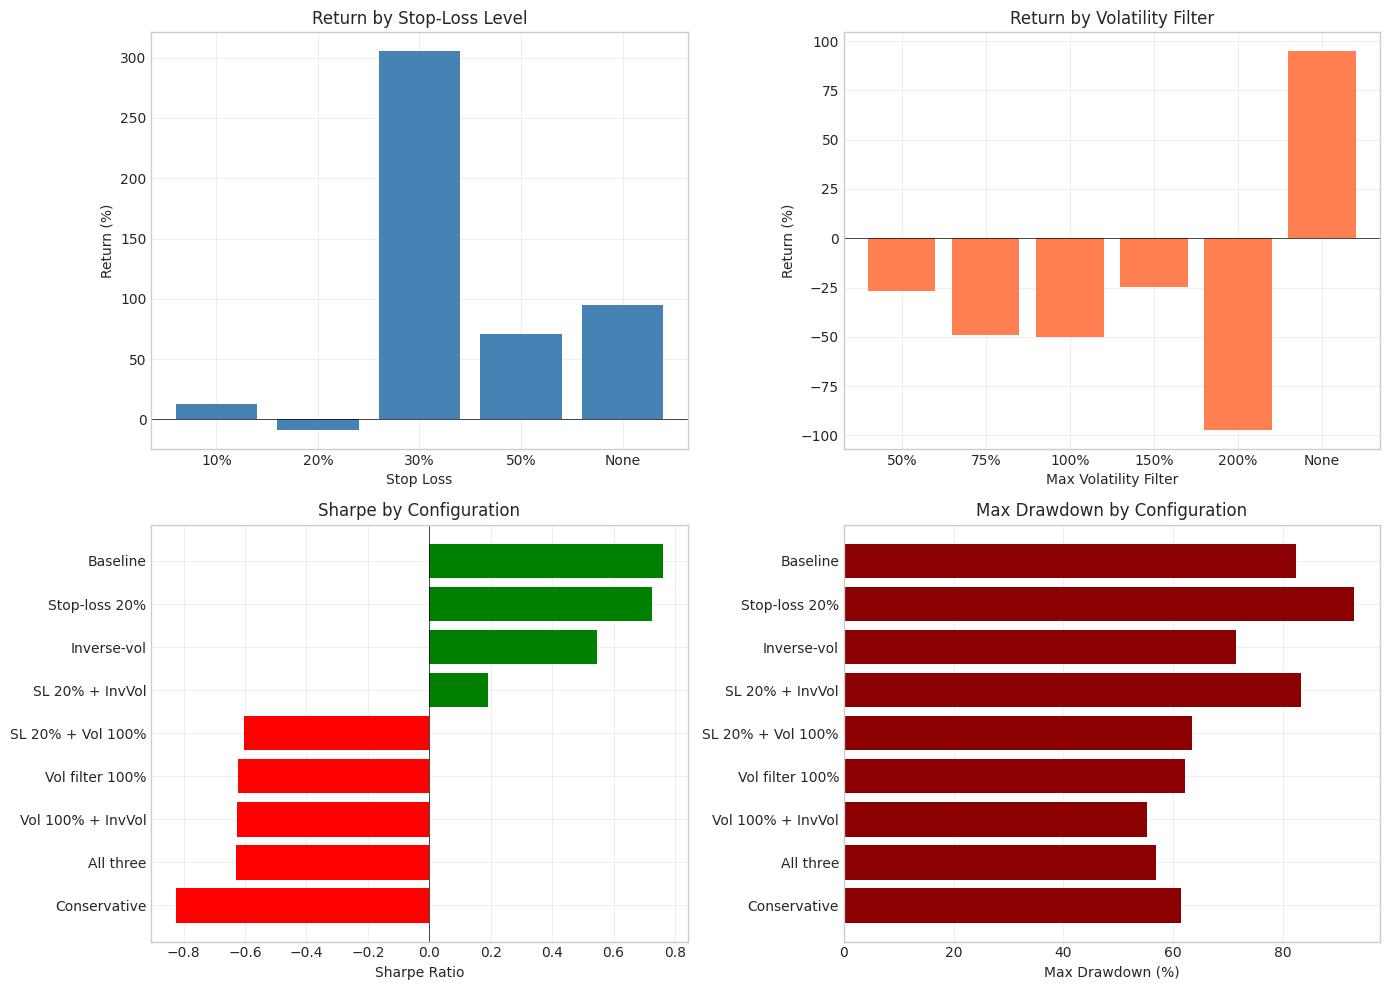

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stop-loss comparison
ax = axes[0, 0]
ax.bar(sl_df['stop_loss'], sl_df['return_pct'], color='steelblue')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Stop Loss')
ax.set_ylabel('Return (%)')
ax.set_title('Return by Stop-Loss Level')
ax.grid(True, alpha=0.3)

# Volatility filter comparison
ax = axes[0, 1]
ax.bar(vol_df['max_vol'], vol_df['return_pct'], color='coral')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Max Volatility Filter')
ax.set_ylabel('Return (%)')
ax.set_title('Return by Volatility Filter')
ax.grid(True, alpha=0.3)

# Sharpe comparison for combined configs
ax = axes[1, 0]
sorted_df = combined_df.sort_values('sharpe', ascending=True)
colors = ['red' if x < 0 else 'green' for x in sorted_df['sharpe']]
ax.barh(sorted_df['config'], sorted_df['sharpe'], color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Sharpe Ratio')
ax.set_title('Sharpe by Configuration')
ax.grid(True, alpha=0.3)

# Max DD comparison
ax = axes[1, 1]
ax.barh(sorted_df['config'], sorted_df['max_dd_pct'], color='darkred')
ax.set_xlabel('Max Drawdown (%)')
ax.set_title('Max Drawdown by Configuration')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

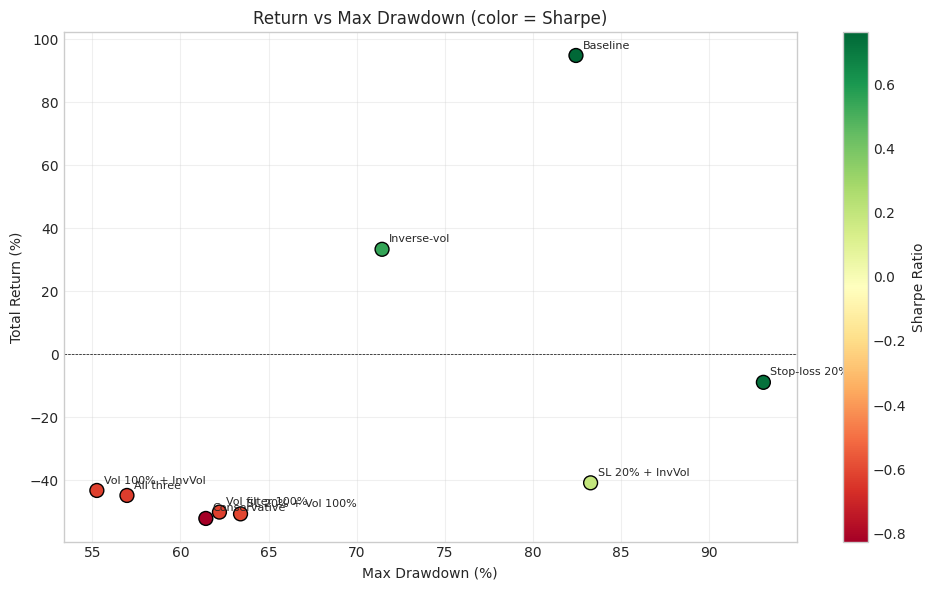

In [27]:
# Risk-adjusted comparison: Return vs Max DD
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(combined_df['max_dd_pct'], combined_df['return_pct'], 
                      c=combined_df['sharpe'], cmap='RdYlGn', s=100, edgecolors='black')

for i, row in combined_df.iterrows():
    ax.annotate(row['config'], (row['max_dd_pct'], row['return_pct']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.colorbar(scatter, label='Sharpe Ratio')
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlabel('Max Drawdown (%)')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs Max Drawdown (color = Sharpe)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Summary

In [28]:
print("=" * 70)
print("SUMMARY")
print("=" * 70)

# Best by Sharpe
best_sharpe = combined_df.loc[combined_df['sharpe'].idxmax()]
print(f"\nBest by Sharpe Ratio:")
print(f"  Config: {best_sharpe['config']}")
print(f"  Sharpe: {best_sharpe['sharpe']:.2f}")
print(f"  Return: {best_sharpe['return_pct']:.1f}%")
print(f"  Max DD: {best_sharpe['max_dd_pct']:.1f}%")

# Best by Return
best_return = combined_df.loc[combined_df['return'].idxmax()]
print(f"\nBest by Total Return:")
print(f"  Config: {best_return['config']}")
print(f"  Return: {best_return['return_pct']:.1f}%")
print(f"  Sharpe: {best_return['sharpe']:.2f}")
print(f"  Max DD: {best_return['max_dd_pct']:.1f}%")

# Best risk-adjusted (Sharpe / MaxDD)
combined_df['risk_adj'] = combined_df['sharpe'] / (combined_df['max_dd'] + 0.01)
best_risk_adj = combined_df.loc[combined_df['risk_adj'].idxmax()]
print(f"\nBest Risk-Adjusted (Sharpe/MaxDD):")
print(f"  Config: {best_risk_adj['config']}")
print(f"  Sharpe: {best_risk_adj['sharpe']:.2f}")
print(f"  Return: {best_risk_adj['return_pct']:.1f}%")
print(f"  Max DD: {best_risk_adj['max_dd_pct']:.1f}%")

# Lowest Max DD with positive Sharpe
positive_sharpe = combined_df[combined_df['sharpe'] > 0]
if len(positive_sharpe) > 0:
    lowest_dd = positive_sharpe.loc[positive_sharpe['max_dd'].idxmin()]
    print(f"\nLowest Max DD (with positive Sharpe):")
    print(f"  Config: {lowest_dd['config']}")
    print(f"  Max DD: {lowest_dd['max_dd_pct']:.1f}%")
    print(f"  Sharpe: {lowest_dd['sharpe']:.2f}")
    print(f"  Return: {lowest_dd['return_pct']:.1f}%")

SUMMARY

Best by Sharpe Ratio:
  Config: Baseline
  Sharpe: 0.76
  Return: 94.8%
  Max DD: 82.4%

Best by Total Return:
  Config: Baseline
  Return: 94.8%
  Sharpe: 0.76
  Max DD: 82.4%

Best Risk-Adjusted (Sharpe/MaxDD):
  Config: Baseline
  Sharpe: 0.76
  Return: 94.8%
  Max DD: 82.4%

Lowest Max DD (with positive Sharpe):
  Config: Inverse-vol
  Max DD: 71.4%
  Sharpe: 0.54
  Return: 33.3%


In [24]:
# Save results
combined_df.to_parquet("data/risk_management_results.pqt")
print("\nSaved results to data/risk_management_results.pqt")


Saved results to data/risk_management_results.pqt
